In [ ]:
!pip install tabulate

In [ ]:
# Parameters example STEP 1
import numpy as np
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt

In [ ]:
# Parameters
S0 = 80      # Spot price
K = S0      # Strike price ATM
T = 3/12        # Time to maturity (in years)
r = 0.055     # Risk-free rate
sigma = 0.35  # Volatility
M0 = 500 # Number of steps in a year
I = 10_000 # Number of MC iteration

# Heston param
v0 = 0.032
kappa_v = 1.85
theta_v = 0.045

# Stochastic volatility modeling: Heston model

In [ ]:
# European option pricer
def heston_european_option(S0, K, r, rho, v0, kappa, theta, sigma, T, M0, I, is_call=True):
    M = int(M0*T) # Total time steps
    dt = T/M  # Length of time step
    sdt = np.sqrt(dt)
    v = np.zeros((M + 1, I), dtype=float)
    S = np.zeros((M+1, I), dtype=float)
    S[0] = S0
    v[0] = v0

    # Generating random numbers from standard normal
    rand = np.random.standard_normal((2, M+1, I))
    rand[1] = rho*rand[0] + np.sqrt(1-rho**2)*rand[1]

    # Generating vol process
    for t in range(1, M + 1):
        v[t] = np.maximum(0, v[t - 1] + kappa * (theta - v[t - 1]) * dt + np.sqrt(v[t - 1]) * sigma * rand[1,t] * sdt)
        S[t] = S[t - 1] * np.exp((r - 0.5 * v[t]) * dt + np.sqrt(v[t]) * rand[0,t] * sdt)

    # Payoff
    payoff = np.maximum(S[-1,:]-K, 0) if is_call else np.maximum(K-S[-1,:], 0)
    return np.exp(-r*T)*np.mean(payoff)

# American option pricer
def heston_american_option(S0, K, r, rho, v0, kappa, theta, sigma, T, M0, I, is_call=True):
    M = int(M0*T) # Total time steps
    dt = T/M  # Length of time step
    sdt = np.sqrt(dt)
    v = np.zeros((M + 1, I), dtype=float)
    S = np.zeros((M+1, I), dtype=float)
    options_path = np.zeros((M + 1, I), dtype=float)
    payoff = np.zeros((M + 1, I), dtype=float)
    S[0] = S0
    v[0] = v0

    # Generating random numbers from standard normal
    rand = np.random.standard_normal((2, M+1, I))
    rand[1] = rho*rand[0] + np.sqrt(1-rho**2)*rand[1]

    # Generating vol process
    for t in range(1, M + 1):
        v[t] = np.maximum(0, v[t - 1] + kappa * (theta - v[t - 1]) * dt + np.sqrt(v[t - 1]) * sigma * rand[1,t] * sdt)
        S[t] = S[t - 1] * np.exp((r - 0.5 * v[t]) * dt + np.sqrt(v[t]) * rand[0,t] * sdt)

    # Payoff
    payoff = np.maximum(S-K, 0) if is_call else np.maximum(K-S, 0)
    options_path[-1] = payoff[-1]
    for t in reversed(range(M)):
        options_path[t] = np.maximum(payoff[t], np.exp(-r*dt)*options_path[t+1]) if is_call else np.maximum(payoff[t], options_path[t+1])
    return np.mean(options_path[0])

# Delta using central difference method
def heston_delta(S0, K, r, rho, v0, kappa, theta, sigma, T, M0, I, pricer, is_call=True):
  epsilon = 1e-2
  option_up = pricer(S0*( 1 + epsilon), K, r, rho, v0, kappa_v, theta_v, sigma, T, M0, I, is_call)
  option_down = pricer(S0*(1 - epsilon), K, r, rho, v0, kappa_v, theta_v, sigma, T, M0, I, is_call)
  option_delta = (option_up - option_down) / (2 * epsilon * S0)
  return option_delta

# Gamma using central difference method
def heston_gamma(S0, K, r, rho, v0, kappa, theta, sigma, T, M0, I, pricer, is_call=True):
  epsilon = 1e-2
  option = pricer(S0, K, r, rho, v0, kappa_v, theta_v, sigma, T, M0, I, is_call)
  option_up = pricer(S0*( 1 + epsilon), K, r, rho, v0, kappa_v, theta_v, sigma, T, M0, I, is_call)
  option_down = pricer(S0*( 1 - epsilon), K, r, rho, v0, kappa_v, theta_v, sigma, T, M0, I, is_call)
  option_gamma = (option_up + option_down - 2 * option) / ((S0 * epsilon) ** 2)
  return option_gamma

## European option pricing

In [ ]:
rho = -0.30
# Compute option prices
np.random.seed(0)
price_call = heston_european_option(S0, K, r, rho, v0, kappa_v, theta_v, sigma, T, M0, I, is_call=True)
price_put = heston_european_option(S0, K, r, rho, v0, kappa_v, theta_v, sigma, T, M0, I, is_call=False)

# Compute Delta using central difference method
delta_call = heston_delta(S0, K, r, rho, v0, kappa_v, theta_v, sigma, T, M0, I, pricer=heston_european_option, is_call=True)
delta_put = heston_delta(S0, K, r, rho, v0, kappa_v, theta_v, sigma, T, M0, I, pricer=heston_european_option,is_call=False)

# Compute Gamma using central difference method
gamma_call = heston_gamma(S0, K, r, rho, v0, kappa_v, theta_v, sigma, T, M0, I, pricer=heston_european_option,is_call=True)
gamma_put = heston_gamma(S0, K, r, rho, v0, kappa_v, theta_v, sigma, T, M0, I, pricer=heston_european_option,is_call=False)


# Create results table
results = pd.DataFrame({
    "Option's type": ['Call', 'Put', 'Put - call'],
    'Price': [price_call, price_put, price_put - price_call],
    'Delta': [delta_call, delta_put, None],
    'Gamma': [gamma_call, gamma_put, None],
    'Theoretical_parity': [None, None,  S0 - K * np.exp(-r * T)]

})

# Display results
headers = ["Option's type", 'Price', 'Delta', 'Gamma', 'Theoretical_parity']
print(tabulate(results.round(2), headers=headers, tablefmt="pretty", floatfmt=".4f"))


+---+---------------+-------+-------+-------+--------------------+
|   | Option's type | Price | Delta | Gamma | Theoretical_parity |
+---+---------------+-------+-------+-------+--------------------+
| 0 |     Call      | 2.88  | 0.53  | -0.2  |        nan         |
| 1 |      Put      |  2.8  | -0.46 | 0.15  |        nan         |
| 2 |  Put - call   | -0.08 |  nan  |  nan  |        1.09        |
+---+---------------+-------+-------+-------+--------------------+


In [ ]:
rho = -0.70
# Compute option prices
np.random.seed(0)
price_call = heston_european_option(S0, K, r, rho, v0, kappa_v, theta_v, sigma, T, M0, I, is_call=True)
price_put = heston_european_option(S0, K, r, rho, v0, kappa_v, theta_v, sigma, T, M0, I, is_call=False)

# Compute Delta using central difference method
delta_call = heston_delta(S0, K, r, rho, v0, kappa_v, theta_v, sigma, T, M0, I, pricer=heston_european_option,is_call=True)
delta_put = heston_delta(S0, K, r, rho, v0, kappa_v, theta_v, sigma, T, M0, I, pricer=heston_european_option,is_call=False)

# Compute Gamma using central difference method
gamma_call = heston_gamma(S0, K, r, rho, v0, kappa_v, theta_v, sigma, T, M0, I, pricer=heston_european_option,is_call=True)
gamma_put = heston_gamma(S0, K, r, rho, v0, kappa_v, theta_v, sigma, T, M0, I, pricer=heston_european_option,is_call=False)


# Create results table
results = pd.DataFrame({
    "Option's type": ['Call', 'Put', 'Put - call'],
    'Price': [price_call, price_put, price_put - price_call],
    'Delta': [delta_call, delta_put, None],
    'Gamma': [gamma_call, gamma_put, None],
    'Theoretical_parity': [None, None,  S0 - K * np.exp(-r * T)]

})

# Display results
headers = ["Option's type", 'Price', 'Delta', 'Gamma', 'Theoretical_parity']
print(tabulate(results.round(2), headers=headers, tablefmt="pretty", floatfmt=".4f"))


+---+---------------+-------+-------+-------+--------------------+
|   | Option's type | Price | Delta | Gamma | Theoretical_parity |
+---+---------------+-------+-------+-------+--------------------+
| 0 |     Call      | 2.13  | 0.47  | -0.12 |        nan         |
| 1 |      Put      | 3.42  | -0.5  | 0.17  |        nan         |
| 2 |  Put - call   | 1.29  |  nan  |  nan  |        1.09        |
+---+---------------+-------+-------+-------+--------------------+


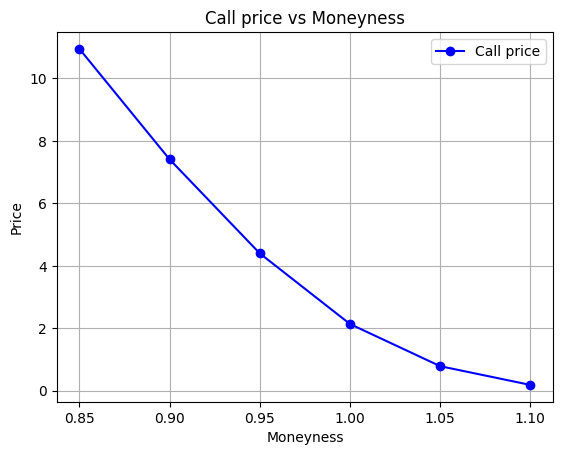

In [ ]:
np.random.seed(0)
strikes = S0 * np.array([0.85, 0.90, 0.95, 1.0, 1.05, 1.10])
call_prices = np.array([heston_european_option(S0, strike, r,
                                               rho, v0, kappa_v, theta_v, sigma,
                                               T, M0, I, is_call=True)
                                               for strike in strikes ])
plt.plot(strikes/S0, call_prices, 'bo-', label="Call price")
plt.xlabel("Moneyness")
plt.ylabel("Price")
plt.title("Call price vs Moneyness")
plt.legend()
plt.grid()

## American option pricing

In [ ]:
rho = -0.30
# Compute option prices
np.random.seed(0)
price_call = heston_american_option(S0, K, r, rho, v0, kappa_v, theta_v, sigma, T, M0, I, is_call=True)
price_put = heston_american_option(S0, K, r, rho, v0, kappa_v, theta_v, sigma, T, M0, I, is_call=False)

# Compute Delta using central difference method
delta_call = heston_delta(S0, K, r, rho, v0, kappa_v, theta_v, sigma, T, M0, I, pricer=heston_american_option, is_call=True)
delta_put = heston_delta(S0, K, r, rho, v0, kappa_v, theta_v, sigma, T, M0, I, pricer=heston_american_option,is_call=False)

# Compute Gamma using central difference method
gamma_call = heston_gamma(S0, K, r, rho, v0, kappa_v, theta_v, sigma, T, M0, I, pricer=heston_american_option,is_call=True)
gamma_put = heston_gamma(S0, K, r, rho, v0, kappa_v, theta_v, sigma, T, M0, I, pricer=heston_american_option,is_call=False)


# Create results table
results = pd.DataFrame({
    "Option's type": ['Call', 'Put', 'Put - call'],
    'Price': [price_call, price_put, price_put - price_call],
    'Delta': [delta_call, delta_put, None],
    'Gamma': [gamma_call, gamma_put, None],
    'Theoretical_parity': [None, None,  S0 - K * np.exp(-r * T)]

})

# Display results
headers = ["Option's type", 'Price', 'Delta', 'Gamma', 'Theoretical_parity']
print(tabulate(results.round(2), headers=headers, tablefmt="pretty", floatfmt=".4f"))


+---+---------------+-------+-------+-------+--------------------+
|   | Option's type | Price | Delta | Gamma | Theoretical_parity |
+---+---------------+-------+-------+-------+--------------------+
| 0 |     Call      | 5.33  | 1.01  | -0.26 |        nan         |
| 1 |      Put      |  5.4  | -0.9  | 0.18  |        nan         |
| 2 |  Put - call   | 0.06  |  nan  |  nan  |        1.09        |
+---+---------------+-------+-------+-------+--------------------+


In [ ]:
rho = -0.70
# Compute option prices
np.random.seed(0)
price_call = heston_american_option(S0, K, r, rho, v0, kappa_v, theta_v, sigma, T, M0, I, is_call=True)
price_put = heston_american_option(S0, K, r, rho, v0, kappa_v, theta_v, sigma, T, M0, I, is_call=False)

# Compute Delta using central difference method
delta_call = heston_delta(S0, K, r, rho, v0, kappa_v, theta_v, sigma, T, M0, I, pricer=heston_american_option,is_call=True)
delta_put = heston_delta(S0, K, r, rho, v0, kappa_v, theta_v, sigma, T, M0, I, pricer=heston_american_option,is_call=False)

# Compute Gamma using central difference method
gamma_call = heston_gamma(S0, K, r, rho, v0, kappa_v, theta_v, sigma, T, M0, I, pricer=heston_american_option,is_call=True)
gamma_put = heston_gamma(S0, K, r, rho, v0, kappa_v, theta_v, sigma, T, M0, I, pricer=heston_american_option,is_call=False)


# Create results table
results = pd.DataFrame({
    "Option's type": ['Call', 'Put', 'Put - call'],
    'Price': [price_call, price_put, price_put - price_call],
    'Delta': [delta_call, delta_put, None],
    'Gamma': [gamma_call, gamma_put, None],
    'Theoretical_parity': [None, None,  S0 - K * np.exp(-r * T)]

})

# Display results
headers = ["Option's type", 'Price', 'Delta', 'Gamma', 'Theoretical_parity']
print(tabulate(results.round(2), headers=headers, tablefmt="pretty", floatfmt=".4f"))


+---+---------------+-------+-------+-------+--------------------+
|   | Option's type | Price | Delta | Gamma | Theoretical_parity |
+---+---------------+-------+-------+-------+--------------------+
| 0 |     Call      | 4.27  | 0.99  | -0.14 |        nan         |
| 1 |      Put      | 6.21  | -0.9  | 0.19  |        nan         |
| 2 |  Put - call   | 1.94  |  nan  |  nan  |        1.09        |
+---+---------------+-------+-------+-------+--------------------+


## European up-and-in call

In [ ]:
# European option pricer
# B is the barrier level
def heston_european_CUI(S0, K, r, B, rho, v0, kappa, theta, sigma, T, M0, I):
    M = int(M0*T) # Total time steps
    dt = T/M  # Length of time step
    sdt = np.sqrt(dt)
    v = np.zeros((M + 1, I), dtype=float)
    S = np.zeros((M+1, I), dtype=float)
    S[0] = S0
    v[0] = v0

    # Generating random numbers from standard normal
    rand = np.random.standard_normal((2, M+1, I))
    rand[1] = rho*rand[0] + np.sqrt(1-rho**2)*rand[1]

    # Generating vol process
    for t in range(1, M + 1):
        v[t] = np.maximum(0, v[t - 1] + kappa * (theta - v[t - 1]) * dt + np.sqrt(v[t - 1]) * sigma * rand[1,t] * sdt)
        S[t] = S[t - 1] * np.exp((r - 0.5 * v[t]) * dt + np.sqrt(v[t]) * rand[0,t] * sdt)

    # Payoff
    barrier_activator = np.where(S > B, 1, 0) # Activating the barrier
    payoff = np.maximum(S[-1,:]-K, 0) * barrier_activator.max(axis=0)
    return np.exp(-r*T)*np.mean(payoff), np.mean(barrier_activator)


def heston_european_PDI(S0, K, r, B, rho, v0, kappa, theta, sigma, T, M0, I):
    M = int(M0*T) # Total time steps
    dt = T/M  # Length of time step
    sdt = np.sqrt(dt)
    v = np.zeros((M + 1, I), dtype=float)
    S = np.zeros((M+1, I), dtype=float)
    S[0] = S0
    v[0] = v0

    # Generating random numbers from standard normal
    rand = np.random.standard_normal((2, M+1, I))
    rand[1] = rho*rand[0] + np.sqrt(1-rho**2)*rand[1]

    # Generating vol process
    for t in range(1, M + 1):
        v[t] = np.maximum(0, v[t - 1] + kappa * (theta - v[t - 1]) * dt + np.sqrt(v[t - 1]) * sigma * rand[1,t] * sdt)
        S[t] = S[t - 1] * np.exp((r - 0.5 * v[t]) * dt + np.sqrt(v[t]) * rand[0,t] * sdt)

    # Payoff
    barrier_activator = np.where(S < B, 1, 0) # Activating the barrier
    payoff = np.maximum(K-S[-1,:], 0) * barrier_activator.max(axis=0)
    return np.exp(-r*T)*np.mean(payoff), np.mean(barrier_activator)

In [ ]:
rho = -0.70
B = 85
K = 90

# Compute option prices
np.random.seed(0)
price_cui, prob_cui = heston_european_CUI(S0, K, r, B, rho, v0, kappa_v, theta_v, sigma, T, M0, I)
price_pdi, prob_pdi = heston_european_PDI(S0, K, r, B, rho, v0, kappa_v, theta_v, sigma, T, M0, I)

# Create results table
results = pd.DataFrame({
    "Option's type": ['CUI', 'PDI'],
    'Price': [price_cui, price_pdi],
    'Probability of activating the barrier': [prob_cui, prob_pdi]
})

# Display results
headers = ["Option's type", 'Price', 'Probability of activating the barrier']
print(tabulate(results.round(2), headers=headers, tablefmt="pretty", floatfmt=".4f"))


+---+---------------+-------+---------------------------------------+
|   | Option's type | Price | Probability of activating the barrier |
+---+---------------+-------+---------------------------------------+
| 0 |      CUI      | 0.08  |                 0.11                  |
| 1 |      PDI      | 11.21 |                 0.89                  |
+---+---------------+-------+---------------------------------------+


**Team Member B: Jump Modeler**
For the Merton model, you can use the following parameters:
- μ =− 0. 5
- δ = 0. 22

**8.** Using the Merton Model, price an ATM European call and an ATM European put with jump intensity parameter equal to 0.75.

In [ ]:
import numpy as np

# Parameters
S0 = 80
r = 0.055
sigma = 0.35
T = 0.25
K = 80
mu_jump = -0.5
delta_jump = 0.22
lambda_jump = 0.75
N_sim = 10000
N_steps = int(500 * T)  # 500 steps per year, adjusted for 0.25 years
dt = T / N_steps

# Compute adjustment factor k
k = np.exp(mu_jump + 0.5 * delta_jump**2) - 1

# Monte Carlo simulation
np.random.seed(0)
S = np.zeros((N_sim, N_steps + 1))
S[:, 0] = S0

for t in range(N_steps):
    Z = np.random.normal(size=N_sim)
    N_jumps = np.random.poisson(lambda_jump * dt, size=N_sim)
    jump_sizes = np.random.normal(mu_jump, delta_jump, size=(N_sim, max(N_jumps) + 1))
    jumps = np.array([np.sum(jump_sizes[i, :N_jumps[i]]) if N_jumps[i] > 0 else 0 for i in range(N_sim)])
    S_t = S[:, t]
    S[:, t + 1] = S_t * np.exp((r - lambda_jump * k - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z + jumps)

# Payoff calculation
call_payoff = np.maximum(S[:, -1] - K, 0)
put_payoff = np.maximum(K - S[:, -1], 0)
call_price = np.exp(-r * T) * np.mean(call_payoff)
put_price = np.exp(-r * T) * np.mean(put_payoff)

# Round to nearest cent
call_price = round(call_price, 2)
put_price = round(put_price, 2)

print("Q8: Merton Model (Jump Intensity = 0.75)")
print(f"European Call Price: {call_price:.2f}")
print(f"European Put Price: {put_price:.2f}")

Q8: Merton Model (Jump Intensity = 0.75)
European Call Price: 8.27
European Put Price: 7.41


**9. Using the Merton Model, price an ATM European call and an ATM European put
with jump intensity parameter equal to 0.25.**

In [ ]:
import numpy as np

# Parameters
S0 = 80
r = 0.055
sigma = 0.35
T = 0.25
K = 80
mu_jump = -0.5
delta_jump = 0.22
lambda_jump = 0.25
N_sim = 10000
N_steps = int(500 * T)  # 125 steps
dt = T / N_steps

# Compute adjustment factor k
k = np.exp(mu_jump + 0.5 * delta_jump**2) - 1

# Monte Carlo simulation
np.random.seed(0)
S = np.zeros((N_sim, N_steps + 1))
S[:, 0] = S0

for t in range(N_steps):
    Z = np.random.normal(size=N_sim)
    N_jumps = np.random.poisson(lambda_jump * dt, size=N_sim)
    jump_sizes = np.random.normal(mu_jump, delta_jump, size=(N_sim, N_steps))
    jumps = np.zeros(N_sim)
    for i in range(N_sim):
        if N_jumps[i] > 0:
            jumps[i] = np.sum(jump_sizes[i, :N_jumps[i]])
    S_t = S[:, t]
    drift = r - lambda_jump * k - 0.5 * sigma**2
    S[:, t + 1] = S_t * np.exp(drift * dt + sigma * np.sqrt(dt) * Z + jumps)

# Payoff calculation
call_payoff = np.maximum(S[:, -1] - K, 0)
put_payoff = np.maximum(K - S[:, -1], 0)
call_price = np.exp(-r * T) * np.mean(call_payoff)
put_price = np.exp(-r * T) * np.mean(put_payoff)

# Round to nearest cent
call_price = round(call_price, 2)
put_price = round(put_price, 2)

print("Q9: Merton Model (Jump Intensity = 0.25)")
print(f"European Call Price: {call_price:.2f}")
print(f"European Put Price: {put_price:.2f}")

Q9: Merton Model (Jump Intensity = 0.25)
European Call Price: 6.73
European Put Price: 5.83


**Q10** Calculate delta and gamma for each of the options in Questions 8 and 9

In [ ]:
import numpy as np

# Parameters
S0 = 80
r = 0.055
sigma = 0.35
T = 0.25
K = 80
mu_jump = -0.5
delta_jump = 0.22
N_sim = 10000
N_steps = int(500 * T)  # 125 steps
dt = T / N_steps
epsilon = 0.01  # Perturbation for numerical approximation

def merton_price(S0, lambda_jump):
    # Compute adjustment factor k
    k = np.exp(mu_jump + 0.5 * delta_jump**2) - 1

    # Monte Carlo simulation
    np.random.seed(0)
    S = np.zeros((N_sim, N_steps + 1))
    S[:, 0] = S0

    for t in range(N_steps):
        Z = np.random.normal(size=N_sim)
        N_jumps = np.random.poisson(lambda_jump * dt, size=N_sim)
        max_jumps = max(N_jumps) if max(N_jumps) > 0 else 1
        jump_sizes = np.random.normal(mu_jump, delta_jump, size=(N_sim, max_jumps))
        jumps = np.zeros(N_sim)
        for i in range(N_sim):
            if N_jumps[i] > 0:
                jumps[i] = np.sum(jump_sizes[i, :N_jumps[i]])
        S_t = S[:, t]
        drift = r - lambda_jump * k - 0.5 * sigma**2
        S[:, t + 1] = S_t * np.exp(drift * dt + sigma * np.sqrt(dt) * Z + jumps)

    # Payoff calculation
    call_payoff = np.maximum(S[:, -1] - K, 0)
    put_payoff = np.maximum(K - S[:, -1], 0)
    call_price = np.exp(-r * T) * np.mean(call_payoff)
    put_price = np.exp(-r * T) * np.mean(put_payoff)
    return call_price, put_price

# Q8: Lambda = 0.75
lambda_jump = 0.75
call_base_q8, put_base_q8 = merton_price(S0, lambda_jump)  # Base prices
call_up_q8, put_up_q8 = merton_price(S0 * (1 + epsilon), lambda_jump)  # S0 + epsilon
call_down_q8, put_down_q8 = merton_price(S0 * (1 - epsilon), lambda_jump)  # S0 - epsilon

# Delta and Gamma for Q8
delta_call_q8 = (call_up_q8 - call_down_q8) / (2 * epsilon * S0)
delta_put_q8 = (put_up_q8 - put_down_q8) / (2 * epsilon * S0)
gamma_call_q8 = (call_up_q8 + call_down_q8 - 2 * call_base_q8) / (epsilon * S0)**2
gamma_put_q8 = (put_up_q8 + put_down_q8 - 2 * put_base_q8) / (epsilon * S0)**2

# Q9: Lambda = 0.25
lambda_jump = 0.25
call_base_q9, put_base_q9 = merton_price(S0, lambda_jump)  # Base prices
call_up_q9, put_up_q9 = merton_price(S0 * (1 + epsilon), lambda_jump)  # S0 + epsilon
call_down_q9, put_down_q9 = merton_price(S0 * (1 - epsilon), lambda_jump)  # S0 - epsilon

# Delta and Gamma for Q9
delta_call_q9 = (call_up_q9 - call_down_q9) / (2 * epsilon * S0)
delta_put_q9 = (put_up_q9 - put_down_q9) / (2 * epsilon * S0)
gamma_call_q9 = (call_up_q9 + call_down_q9 - 2 * call_base_q9) / (epsilon * S0)**2
gamma_put_q9 = (put_up_q9 + put_down_q9 - 2 * put_base_q9) / (epsilon * S0)**2

# Print results
print("Q10: Greeks for Merton Model (Jump Intensity = 0.75)")
print(f"Call Delta: {delta_call_q8:.4f}, Gamma: {gamma_call_q8:.4f}")
print(f"Put Delta: {delta_put_q8:.4f}, Gamma: {gamma_put_q8:.4f}")

print("\nQ10: Greeks for Merton Model (Jump Intensity = 0.25)")
print(f"Call Delta: {delta_call_q9:.4f}, Gamma: {gamma_call_q9:.4f}")
print(f"Put Delta: {delta_put_q9:.4f}, Gamma: {gamma_put_q9:.4f}")

Q10: Greeks for Merton Model (Jump Intensity = 0.75)
Call Delta: 0.6529, Gamma: 0.0208
Put Delta: -0.3481, Gamma: 0.0208

Q10: Greeks for Merton Model (Jump Intensity = 0.25)
Call Delta: 0.5895, Gamma: 0.0264
Put Delta: -0.4092, Gamma: 0.0264


In [ ]:

# Question 11 Team Member C: Model Validator

import numpy as np
import pandas as pd

# -----------------------------------------
# General Parameters
# -----------------------------------------
S0 = 80                # Spot price
K = 80                 # Strike price
r = 0.055              # Risk-free rate
sigma = 0.35           # Volatility for Merton
T = 0.25               # Time to maturity in years
discount_factor = np.exp(-r * T)

# -----------------------------------------
# Heston Parameters
# -----------------------------------------
v0 = 0.032             # Initial variance
kappa_v = 1.85         # Speed of mean reversion
theta_v = 0.045        # Long-run variance

# -----------------------------------------
# Merton Parameters
# -----------------------------------------
mu_j = -0.5            # Mean of jump size
delta_j = 0.22         # Std deviation of jump

# -----------------------------------------
# Monte Carlo Settings
# -----------------------------------------
n_paths = 5000
n_steps = 100

# -----------------------------------------
# Heston Model Simulation
# -----------------------------------------
def simulate_heston(S0, K, T, r, v0, kappa, theta, rho, sigma, n_paths, n_steps):
    dt = T / n_steps
    prices = np.zeros(n_paths)
    for i in range(n_paths):
        S = S0
        v = v0
        for _ in range(n_steps):
            z1 = np.random.normal()
            z2 = rho * z1 + np.sqrt(1 - rho**2) * np.random.normal()
            v = np.abs(v + kappa * (theta - v) * dt + sigma * np.sqrt(v * dt) * z2)
            S *= np.exp((r - 0.5 * v) * dt + np.sqrt(v * dt) * z1)
        prices[i] = S
    call = np.exp(-r * T) * np.mean(np.maximum(prices - K, 0))
    put = np.exp(-r * T) * np.mean(np.maximum(K - prices, 0))
    return call, put

# -----------------------------------------
# Merton Model Simulation
# -----------------------------------------
def simulate_merton(S0, K, T, r, sigma, lamb, mu_j, delta_j, n_paths, n_steps):
    dt = T / n_steps
    prices = np.zeros(n_paths)
    for i in range(n_paths):
        S = S0
        for _ in range(n_steps):
            z = np.random.normal()
            Nj = np.random.poisson(lamb * dt)
            J = np.sum(np.random.normal(mu_j, delta_j, Nj)) if Nj > 0 else 0
            S *= np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z + J)
        prices[i] = S
    call = np.exp(-r * T) * np.mean(np.maximum(prices - K, 0))
    put = np.exp(-r * T) * np.mean(np.maximum(K - prices, 0))
    return call, put

# -----------------------------------------
# Run Simulations for Q5–Q9
# -----------------------------------------
results = []

# Q5 – Heston, rho = -0.30
c5, p5 = simulate_heston(S0, K, T, r, v0, kappa_v, theta_v, -0.30, sigma, n_paths, n_steps)
results.append(["Q5", "Heston", "ρ = -0.30", c5, p5, c5 - p5])

# Q6 – Heston, rho = -0.70
c6, p6 = simulate_heston(S0, K, T, r, v0, kappa_v, theta_v, -0.70, sigma, n_paths, n_steps)
results.append(["Q6", "Heston", "ρ = -0.70", c6, p6, c6 - p6])

# Q8 – Merton, lambda = 0.75
c8, p8 = simulate_merton(S0, K, T, r, sigma, 0.75, mu_j, delta_j, n_paths, n_steps)
results.append(["Q8", "Merton", "λ = 0.75", c8, p8, c8 - p8])

# Q9 – Merton, lambda = 0.25
c9, p9 = simulate_merton(S0, K, T, r, sigma, 0.25, mu_j, delta_j, n_paths, n_steps)
results.append(["Q9", "Merton", "λ = 0.25", c9, p9, c9 - p9])

# -----------------------------------------
# Results Table
# -----------------------------------------
df = pd.DataFrame(results, columns=[
    "Question", "Model", "Parameter", "Call Price", "Put Price", "C - P"
])

df["Call Price"] = df["Call Price"].round(2)
df["Put Price"] = df["Put Price"].round(2)
df["C - P"] = df["C - P"].round(2)

# Theoretical put-call parity
df["Theoretical Parity"] = round(S0 - K * np.exp(-r * T), 2)
df["Parity Satisfied?"] = np.isclose(df["C - P"], df["Theoretical Parity"], atol=0.15)

# -----------------------------------------
# Print Final Table
# -----------------------------------------
print("\nPut-Call Parity Validation Results for Question 11:\n")
print(df.to_string(index=False))


Put-Call Parity Validation Results for Question 11:

Question  Model Parameter  Call Price  Put Price  C - P  Theoretical Parity  Parity Satisfied?
      Q5 Heston ρ = -0.30        2.91       2.73   0.18                1.09              False
      Q6 Heston ρ = -0.70        2.17       3.41  -1.24                1.09              False
      Q8 Merton  λ = 0.75        5.10       9.40  -4.30                1.09              False
      Q9 Merton  λ = 0.25        5.81       6.40  -0.59                1.09              False


In [ ]:
# Question 12 Team Member C: Model Validator

import numpy as np
import pandas as pd

# -----------------------------
# General Parameters
# -----------------------------
S0 = 80
r = 0.055
sigma = 0.35
T = 0.25
discount_factor = np.exp(-r * T)

# -----------------------------
# Heston Parameters
# -----------------------------
v0 = 0.032
kappa_v = 1.85
theta_v = 0.045
rho_heston = -0.30  # fixed for this question

# -----------------------------
# Merton Parameters
# -----------------------------
mu_j = -0.5
delta_j = 0.22
lambda_merton = 0.75  # fixed for this question

# -----------------------------
# Monte Carlo Settings
# -----------------------------
n_paths = 5000
n_steps = 100

# -----------------------------
# Simulation Functions
# -----------------------------
def simulate_heston(S0, K, T, r, v0, kappa, theta, rho, sigma, n_paths, n_steps):
    dt = T / n_steps
    prices = np.zeros(n_paths)
    for i in range(n_paths):
        S = S0
        v = v0
        for _ in range(n_steps):
            z1 = np.random.normal()
            z2 = rho * z1 + np.sqrt(1 - rho**2) * np.random.normal()
            v = np.abs(v + kappa * (theta - v) * dt + sigma * np.sqrt(v * dt) * z2)
            S *= np.exp((r - 0.5 * v) * dt + np.sqrt(v * dt) * z1)
        prices[i] = S
    call = discount_factor * np.mean(np.maximum(prices - K, 0))
    put = discount_factor * np.mean(np.maximum(K - prices, 0))
    return call, put

def simulate_merton(S0, K, T, r, sigma, lamb, mu_j, delta_j, n_paths, n_steps):
    dt = T / n_steps
    prices = np.zeros(n_paths)
    for i in range(n_paths):
        S = S0
        for _ in range(n_steps):
            z = np.random.normal()
            Nj = np.random.poisson(lamb * dt)
            J = np.sum(np.random.normal(mu_j, delta_j, Nj)) if Nj > 0 else 0
            S *= np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z + J)
        prices[i] = S
    call = discount_factor * np.mean(np.maximum(prices - K, 0))
    put = discount_factor * np.mean(np.maximum(K - prices, 0))
    return call, put

# -----------------------------
# Moneyness and Strike Values
# -----------------------------
moneyness_list = [0.85, 0.90, 0.95, 1.00, 1.05, 1.10, 1.15]
strike_list = [round(S0 / m, 2) for m in moneyness_list]

# -----------------------------
# Run Simulations Across Strikes
# -----------------------------
results = []

for m, K in zip(moneyness_list, strike_list):
    call_h, put_h = simulate_heston(S0, K, T, r, v0, kappa_v, theta_v, rho_heston, sigma, n_paths, n_steps)
    call_m, put_m = simulate_merton(S0, K, T, r, sigma, lambda_merton, mu_j, delta_j, n_paths, n_steps)
    results.append([
        K, round(m, 2),
        round(call_h, 2), round(put_h, 2),
        round(call_m, 2), round(put_m, 2)
    ])

# -----------------------------
# Display Results in Table
# -----------------------------
df_strikes = pd.DataFrame(results, columns=[
    "Strike", "Moneyness",
    "Call (Heston)", "Put (Heston)",
    "Call (Merton)", "Put (Merton)"
])

print("\nOption Prices across 7 Strikes (Heston vs Merton Models):\n")
print(df_strikes.to_string(index=False))


Option Prices across 7 Strikes (Heston vs Merton Models):

 Strike  Moneyness  Call (Heston)  Put (Heston)  Call (Merton)  Put (Merton)
  94.12       0.85           0.10         13.94           1.41         19.82
  88.89       0.90           0.42          9.19           2.37         15.39
  84.21       0.95           1.26          5.52           3.58         12.10
  80.00       1.00           2.78          2.98           5.19          9.47
  76.19       1.05           5.10          1.40           6.93          7.33
  72.73       1.10           7.93          0.66           8.66          5.93
  69.57       1.15          10.56          0.28          10.51          5.05


In [ ]:
# STEP2 QUESTION 13, 14 AND 15

import numpy as np
import pandas as pd

# General Settings
S0 = 80
K = 80
r = 0.055
T = 0.25
n_paths = 10000
n_steps = 50
dt = T / n_steps
discount = np.exp(-r * dt)

# Heston Parameters (Q13)
v0 = 0.032
kappa = 1.85
theta = 0.045
sigma_v = 0.35
rho = -0.30

# Merton Parameters (Q14 and Q15)
sigma_m = 0.35
lambda_m = 0.75
mu_j = -0.5
delta_j = 0.22

# Basis functions for LSM
def regression_basis(S):
    return np.vstack([np.ones_like(S), S, S**2]).T

# Heston Path Simulation
def simulate_heston_paths(S0, v0, r, T, kappa, theta, sigma_v, rho, n_paths, n_steps):
    S = np.zeros((n_paths, n_steps + 1))
    v = np.zeros((n_paths, n_steps + 1))
    S[:, 0], v[:, 0] = S0, v0
    for t in range(1, n_steps + 1):
        z1 = np.random.normal(size=n_paths)
        z2 = rho * z1 + np.sqrt(1 - rho**2) * np.random.normal(size=n_paths)
        v[:, t] = np.abs(v[:, t-1] + kappa * (theta - v[:, t-1]) * dt + sigma_v * np.sqrt(v[:, t-1] * dt) * z2)
        S[:, t] = S[:, t-1] * np.exp((r - 0.5 * v[:, t-1]) * dt + np.sqrt(v[:, t-1] * dt) * z1)
    return S

# Merton Path Simulation
def simulate_merton_paths(S0, r, sigma, lamb, mu_j, delta_j, n_paths, n_steps):
    S = np.zeros((n_paths, n_steps + 1))
    S[:, 0] = S0
    for t in range(1, n_steps + 1):
        Z = np.random.normal(size=n_paths)
        N = np.random.poisson(lamb * dt, size=n_paths)
        J = np.random.normal(mu_j, delta_j, size=(n_paths, np.max(N)+1))
        jump_sum = np.array([np.sum(J[i, :N[i]]) if N[i] > 0 else 0 for i in range(n_paths)])
        S[:, t] = S[:, t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z + jump_sum)
    return S

# LSM Pricing for American Options
def price_american_option_lsm(S_paths, K, r, T, option_type='call'):
    n_paths, n_steps = S_paths.shape
    n_steps -= 1
    dt = T / n_steps
    if option_type == 'call':
        payoff = np.maximum(S_paths[:, -1] - K, 0)
    else:
        payoff = np.maximum(K - S_paths[:, -1], 0)
    exercise_time = np.full(n_paths, n_steps)

    for t in range(n_steps - 1, 0, -1):
        if option_type == 'call':
            itm = np.where(S_paths[:, t] > K)[0]
            intrinsic = S_paths[:, t] - K
        else:
            itm = np.where(S_paths[:, t] < K)[0]
            intrinsic = K - S_paths[:, t]
        if len(itm) == 0:
            continue
        X = regression_basis(S_paths[itm, t])
        y = payoff[itm] * discount**(exercise_time[itm] - t)
        beta = np.linalg.lstsq(X, y, rcond=None)[0]
        continuation = X @ beta
        exercise = intrinsic[itm] > continuation
        idx_exercise = itm[exercise]
        payoff[idx_exercise] = intrinsic[idx_exercise]
        exercise_time[idx_exercise] = t

    return np.mean(payoff * discount**exercise_time)

# Estimate Greeks via finite difference
def estimate_greeks(model, S0, bump=0.5, option_type='call'):
    if model == 'heston':
        base = simulate_heston_paths(S0, v0, r, T, kappa, theta, sigma_v, rho, n_paths, n_steps)
        up = simulate_heston_paths(S0 + bump, v0, r, T, kappa, theta, sigma_v, rho, n_paths, n_steps)
        down = simulate_heston_paths(S0 - bump, v0, r, T, kappa, theta, sigma_v, rho, n_paths, n_steps)
    elif model == 'merton':
        base = simulate_merton_paths(S0, r, sigma_m, lambda_m, mu_j, delta_j, n_paths, n_steps)
        up = simulate_merton_paths(S0 + bump, r, sigma_m, lambda_m, mu_j, delta_j, n_paths, n_steps)
        down = simulate_merton_paths(S0 - bump, r, sigma_m, lambda_m, mu_j, delta_j, n_paths, n_steps)
    else:
        raise ValueError("Model must be 'heston' or 'merton'")

    price = price_american_option_lsm(base, K, r, T, option_type)
    price_up = price_american_option_lsm(up, K, r, T, option_type)
    price_down = price_american_option_lsm(down, K, r, T, option_type)

    delta = (price_up - price_down) / (2 * bump)
    gamma = (price_up - 2 * price + price_down) / (bump ** 2)

    return price, delta, gamma

# Run for Q13 (Heston American Call)
price_13, delta_13, gamma_13 = estimate_greeks('heston', S0, option_type='call')

# Run for Q14 (Merton American Put)
price_14, delta_14, gamma_14 = estimate_greeks('merton', S0, option_type='put')

# Run for Q15 (Merton American Call)
price_15, delta_15, gamma_15 = estimate_greeks('merton', S0, option_type='call')

# Assemble results
results_step2 = pd.DataFrame([
    {"Question": "Q13", "Model": "Heston (American Call)", "Price": round(price_13, 4), "Delta": round(delta_13, 4), "Gamma": round(gamma_13, 4)},
    {"Question": "Q14", "Model": "Merton (American Put)", "Price": round(price_14, 4), "Delta": round(delta_14, 4), "Gamma": round(gamma_14, 4)},
    {"Question": "Q15", "Model": "Merton (American Call)", "Price": round(price_15, 4), "Delta": round(delta_15, 4), "Gamma": round(gamma_15, 4)},
])

results_step2
# Print the results to the console
print("\nFinal Results – Step 2 (Questions 13, 14, 15):\n")
print(results_step2.to_string(index=False))


Final Results – Step 2 (Questions 13, 14, 15):

Question                  Model  Price   Delta  Gamma
     Q13 Heston (American Call) 3.3761  0.5914 0.6409
     Q14  Merton (American Put) 9.3029 -0.5992 1.5203
     Q15 Merton (American Call) 5.2753  0.3389 0.2705
